## Dataset

In [1]:
import os
import shutil

def split_files(src, train, valid, ratio=.8):
    
    # make directory everytime
    os.makedirs(src, exist_ok=True)
    os.makedirs(train, exist_ok=True)
    os.makedirs(valid, exist_ok=True)
    
    src_files = os.listdir(src)
    for idx, file_name in enumerate(src_files):
        full_file_name = os.path.join(src, file_name)
        if os.path.isfile(full_file_name):
                if idx < len(src_files)*ratio:
                    shutil.copy(full_file_name, train)
                else:
                    shutil.copy(full_file_name, valid)
                    
# keep dir clean before copy files
sub_src = '../data/lenses/sub'
sub_train = '../data/lenses_train/sub'
sub_valid = '../data/lenses_valid/sub'
split_files(sub_src, sub_train, sub_valid, .8)

no_sub_src = '../data/lenses/no_sub'
no_sub_train = '../data/lenses_train/no_sub'
no_sub_valid = '../data/lenses_valid/no_sub'
split_files(no_sub_src, no_sub_train, no_sub_valid, .8)

In [2]:
import torch
import torchvision
from torchvision import transforms, datasets

data_transform = transforms.Compose([
#         transforms.RandomResizedCrop(150),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
train_dataset = datasets.ImageFolder(root='../data/lenses_train',
                                           transform=data_transform)
train_loader = torch.utils.data.DataLoader(train_dataset,
                                             batch_size=8, shuffle=True,
                                             num_workers=4)

valid_dataset = datasets.ImageFolder(root='../data/lenses_valid',
                                           transform=data_transform)
valid_loader = torch.utils.data.DataLoader(train_dataset,
                                             batch_size=8, shuffle=True,
                                             num_workers=4)

classes = ('no_sub', 'sub')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


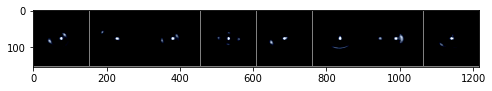

     sub      sub   no_sub   no_sub   no_sub   no_sub      sub      sub


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    plt.figure(figsize=(8,8))
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join('%8s' % classes[labels[j]] for j in range(8)))

## LensesCNN

In [5]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 34 * 34, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), 16 * 34 * 34)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [6]:
import torch.optim as optim
import torch.optim.lr_scheduler

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01,\
#                                         steps_per_epoch=len(train_loader),\
#                                         epochs=3)

In [ ]:
for epoch in range(3):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0.0
            
#         scheduler.step()

print('Finished Training')

[1,   100] loss: 0.078


In [ ]:
PATH = './lenses_net.pth'
torch.save(net.state_dict(), PATH)

In [ ]:
dataiter = iter(valid_loader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(8)))

net = Net()
net.load_state_dict(torch.load(PATH))
outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(8)))

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in valid_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))